Elbow Method - Optimal number of clusters: 8


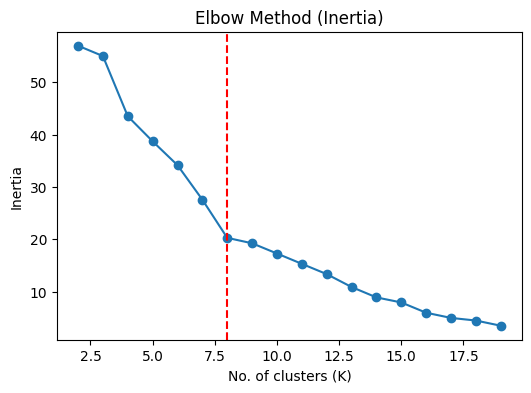

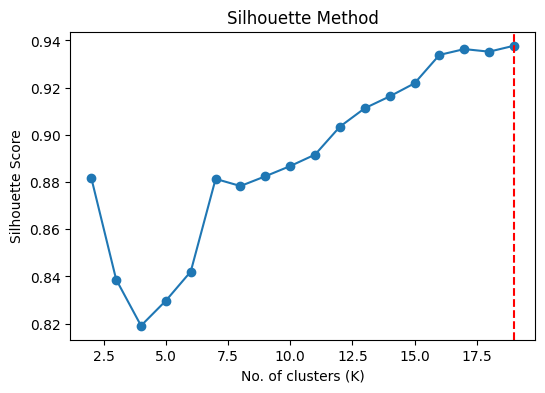

Silhouette Method - Optimal number of clusters: 19


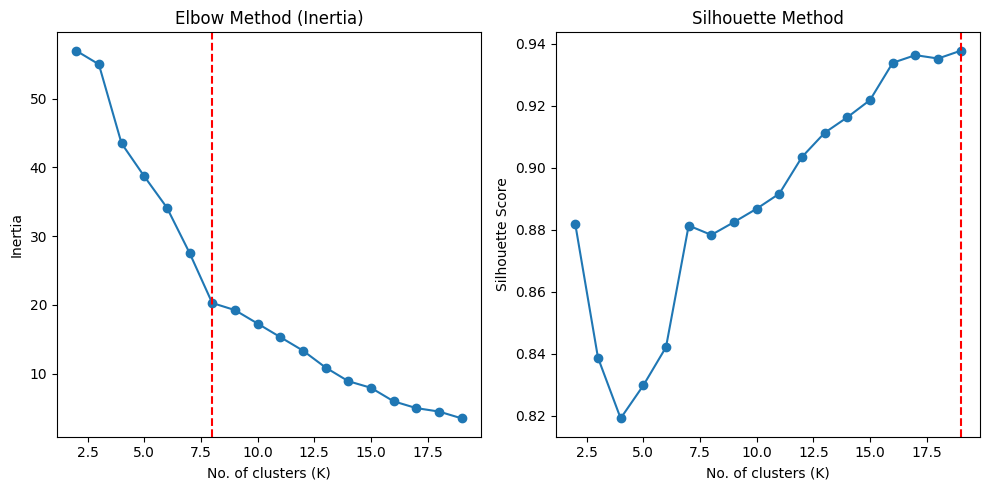

Combined Method - Final number of clusters: 15
Elbow Method - Optimal number of clusters: 8


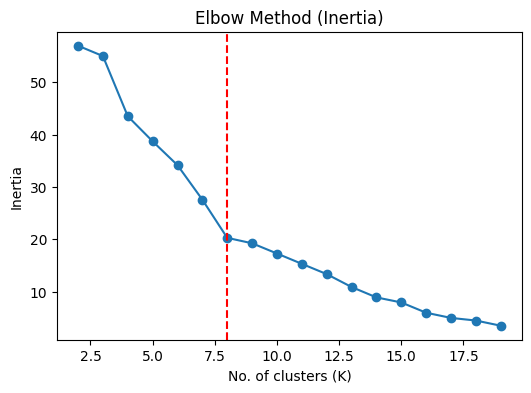

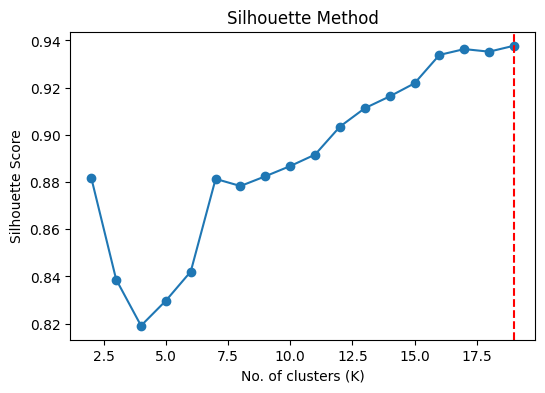

Silhouette Method - Optimal number of clusters: 19


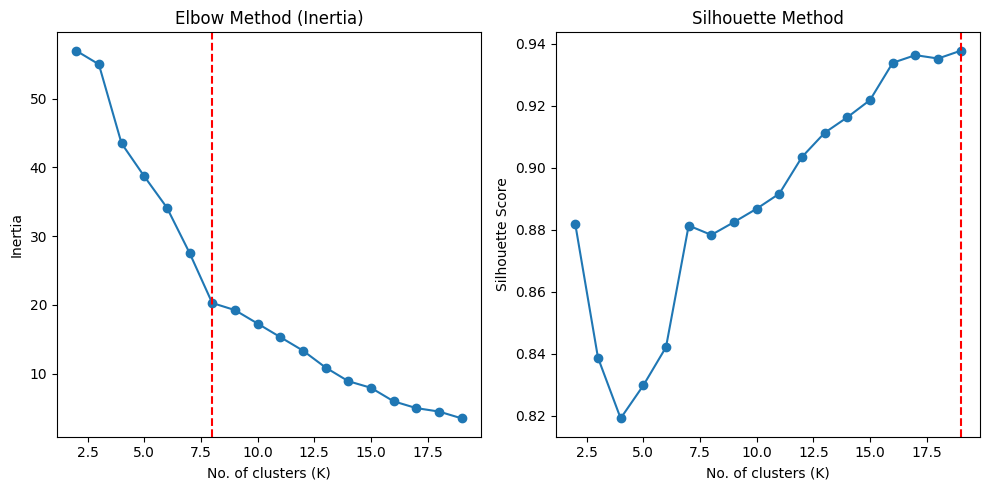

Combined Method - Final number of clusters: 15


In [1]:
from Main import clean_save_csv, optimal_clusters

csv_file_path = clean_save_csv()
best_k_elbow, best_k_silhouette, best_k_combined = optimal_clusters(csv_file_path, max_clusters=20, alpha=0.6, plot=True)

FileNotFoundError: [Errno 2] No such file or directory: 'multi_hot_encoded_data.csv'

FileNotFoundError: [Errno 2] No such file or directory: 'multi_hot_encoded_data.csv'

Elbow Method - Optimal number of clusters: 8


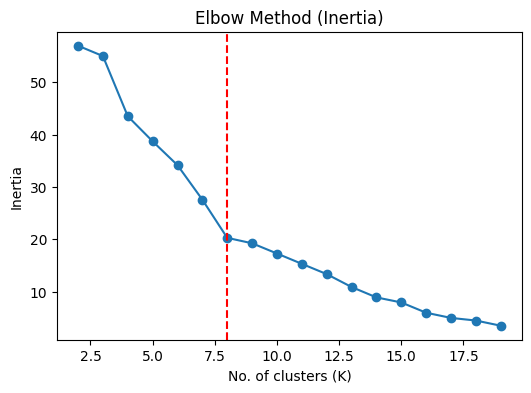

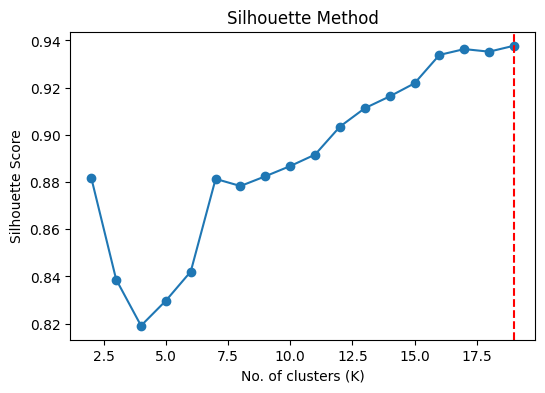

Silhouette Method - Optimal number of clusters: 19


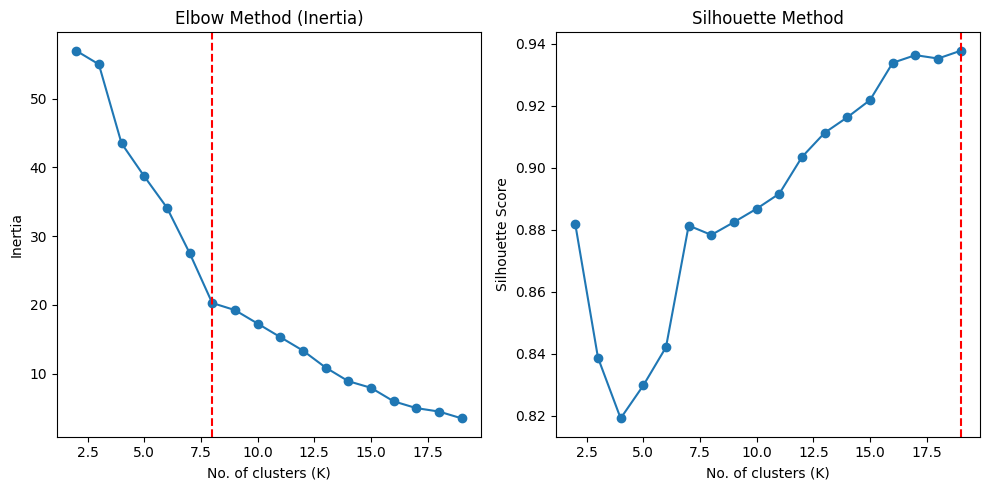

Combined Method - Final number of clusters: 11


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt

file_path = "/Users/Alexander/Downloads/IDC_SQL_lib-main/IDC_SQL_lib-main/multi_hot_encoded_dataset.csv"

# Load the dataset
def load_dataset(file_path):
    data = pd.read_csv(file_path)
    # Assuming binary columns are the ones to use for clustering
    binary_columns = data.select_dtypes(include=['bool'])
    X = binary_columns.astype(int)  # Convert True/False to 1/0
    return X

# Elbow method using kneed to find the optimal number of clusters
def find_best_k_elbow(X, max_clusters=20):
    """
    Find the optimal number of clusters using the elbow method (inertia).
    """
    options = range(2, max_clusters)
    inertias = []

    for n_clusters in options:
        model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
        inertias.append(model.inertia_)

    # Use KneeLocator to detect the "elbow"
    knee_locator = KneeLocator(options, inertias, curve="convex", direction="decreasing")
    best_k_elbow = knee_locator.elbow

    print(f"Elbow Method - Optimal number of clusters: {best_k_elbow}")
    
    # Plot inertia vs number of clusters
    plt.figure(figsize=(6, 4))
    plt.plot(options, inertias, '-o')
    plt.axvline(best_k_elbow, color='red', linestyle='--')
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("No. of clusters (K)")
    plt.ylabel("Inertia")
    plt.show()

    return best_k_elbow

# Silhouette method to find the optimal number of clusters
def find_best_k_silhouette(X, max_clusters=20):
    """
    Find the optimal number of clusters using the silhouette method.
    """
    options = range(2, max_clusters)
    silhouette_scores = []

    for n_clusters in options:
        model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
        labels = model.labels_
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    # Plot silhouette scores
    plt.figure(figsize=(6, 4))
    plt.plot(options, silhouette_scores, '-o')
    plt.axvline(np.argmax(silhouette_scores) + 2, color='red', linestyle='--')  # Offset +2 because range starts at 2
    plt.title("Silhouette Method")
    plt.xlabel("No. of clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.show()

    # Find the number of clusters that maximizes the silhouette score
    best_k_silhouette = options[np.argmax(silhouette_scores)]
    print(f"Silhouette Method - Optimal number of clusters: {best_k_silhouette}")
    return best_k_silhouette

# Combine both methods by weighting the silhouette result against the elbow result
def combine_elbow_and_silhouette(K_elbow, K_silhouette, alpha=0.5):
    """
    Combine the results of the elbow and silhouette methods to find a final K.
    The alpha parameter controls how much weight to give to the silhouette method.
    """
    # Calculate the final K as a weighted average
    K_final = K_elbow + alpha * (K_silhouette - K_elbow)
    return round(K_final)

# Main function to compare and combine both methods
def compare_and_combine_elbow_and_silhouette(X, max_clusters=20, alpha=0.5, plot=False):
    # Get best K for each method
    best_k_elbow = find_best_k_elbow(X, max_clusters)
    best_k_silhouette = find_best_k_silhouette(X, max_clusters)
    
    # Combine the two results to find the final K
    best_k_combined = combine_elbow_and_silhouette(best_k_elbow, best_k_silhouette, alpha=alpha)

    if plot:
        # Plot inertia vs number of clusters for elbow method
        plt.figure(figsize=(10, 5))
        
        # Elbow Method plot (inertia)
        plt.subplot(1, 2, 1)
        inertias = []
        options = range(2, max_clusters)
        for n_clusters in options:
            model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            inertias.append(model.inertia_)
        plt.plot(options, inertias, '-o')
        plt.axvline(best_k_elbow, color='red', linestyle='--')
        plt.title("Elbow Method (Inertia)")
        plt.xlabel("No. of clusters (K)")
        plt.ylabel("Inertia")
        
        # Silhouette Method plot (silhouette scores)
        plt.subplot(1, 2, 2)
        silhouette_scores = []
        for n_clusters in options:
            model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            labels = model.labels_
            score = silhouette_score(X, labels)
            silhouette_scores.append(score)
        plt.plot(options, silhouette_scores, '-o')
        plt.axvline(best_k_silhouette, color='red', linestyle='--')
        plt.title("Silhouette Method")
        plt.xlabel("No. of clusters (K)")
        plt.ylabel("Silhouette Score")
        
        plt.tight_layout()
        plt.show()

    print(f"Combined Method - Final number of clusters: {best_k_combined}")
    return best_k_elbow, best_k_silhouette, best_k_combined

X = load_dataset(file_path)
best_k_elbow, best_k_silhouette, best_k_combined = compare_and_combine_elbow_and_silhouette(X, max_clusters=20, alpha=0.3, plot=True)


Elbow Method - Optimal number of clusters: 8


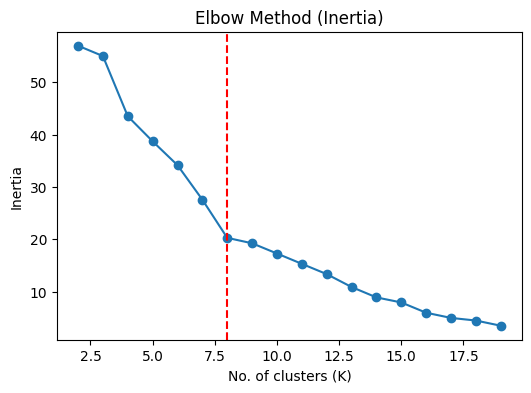

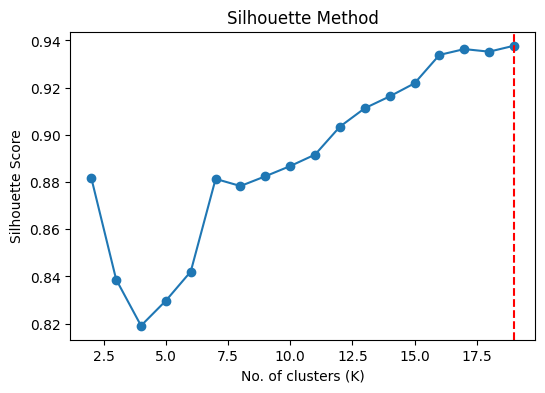

Silhouette Method - Optimal number of clusters: 19


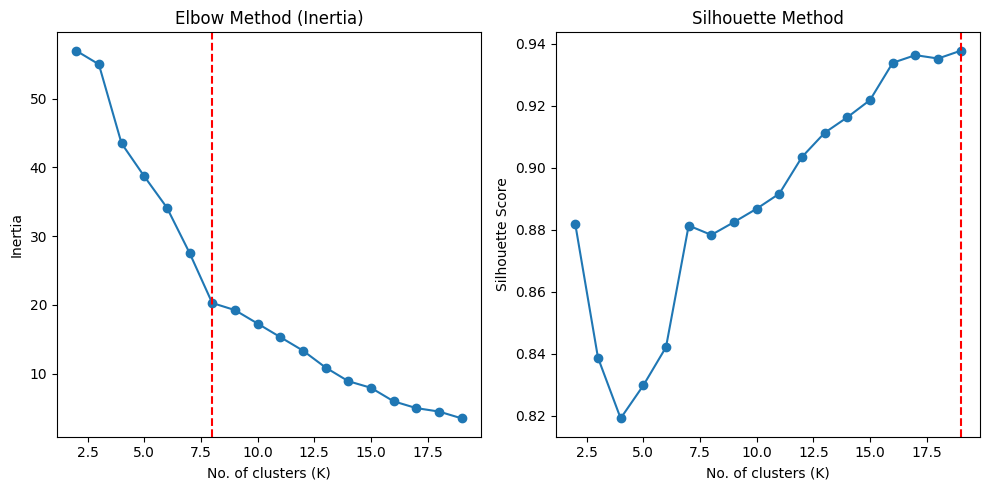

Combined Method - Final number of clusters: 11


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt

file_path= ""

def optimal_clusters(file_path, max_clusters=20, alpha=0.5, plot=True):
    """
    Analyze the optimal number of clusters in a dataset using both the Elbow and Silhouette methods.
    
    :param file_path: Path to the CSV file containing the dataset.
    :param max_clusters: Maximum number of clusters to consider (default is 20).
    :param alpha: Weight to give the Silhouette method when combining the results (default is 0.5).
    :param plot: Whether to plot the results (default is True).
    :return: Tuple containing the optimal number of clusters from the Elbow method, Silhouette method, and the combined result.
    """
    
    # Load the dataset
    def load_dataset(file_path):
        data = pd.read_csv(file_path)
        # Assuming binary columns are the ones to use for clustering
        binary_columns = data.select_dtypes(include=['bool'])
        X = binary_columns.astype(int)  # Convert True/False to 1/0
        return X

    # Elbow method using kneed to find the optimal number of clusters
    def find_best_k_elbow(X, max_clusters=20):
        options = range(2, max_clusters)
        inertias = []

        for n_clusters in options:
            model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            inertias.append(model.inertia_)

        knee_locator = KneeLocator(options, inertias, curve="convex", direction="decreasing")
        best_k_elbow = knee_locator.elbow

        print(f"Elbow Method - Optimal number of clusters: {best_k_elbow}")

        # Plot inertia vs number of clusters
        if plot:
            plt.figure(figsize=(6, 4))
            plt.plot(options, inertias, '-o')
            plt.axvline(best_k_elbow, color='red', linestyle='--')
            plt.title("Elbow Method (Inertia)")
            plt.xlabel("No. of clusters (K)")
            plt.ylabel("Inertia")
            plt.show()

        return best_k_elbow

    # Silhouette method to find the optimal number of clusters
    def find_best_k_silhouette(X, max_clusters=20):
        options = range(2, max_clusters)
        silhouette_scores = []

        for n_clusters in options:
            model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            labels = model.labels_
            score = silhouette_score(X, labels)
            silhouette_scores.append(score)

        # Plot silhouette scores
        if plot:
            plt.figure(figsize=(6, 4))
            plt.plot(options, silhouette_scores, '-o')
            plt.axvline(np.argmax(silhouette_scores) + 2, color='red', linestyle='--')  # Offset +2 because range starts at 2
            plt.title("Silhouette Method")
            plt.xlabel("No. of clusters (K)")
            plt.ylabel("Silhouette Score")
            plt.show()

        best_k_silhouette = options[np.argmax(silhouette_scores)]
        print(f"Silhouette Method - Optimal number of clusters: {best_k_silhouette}")
        return best_k_silhouette

    # Combine both methods by weighting the silhouette result against the elbow result
    def combine_elbow_and_silhouette(K_elbow, K_silhouette, alpha=0.5):
        K_final = K_elbow + alpha * (K_silhouette - K_elbow)
        return round(K_final)

    # Main logic
    X = load_dataset(file_path)
    best_k_elbow = find_best_k_elbow(X, max_clusters)
    best_k_silhouette = find_best_k_silhouette(X, max_clusters)
    best_k_combined = combine_elbow_and_silhouette(best_k_elbow, best_k_silhouette, alpha)

    if plot:
        # Plot inertia vs number of clusters for elbow method
        plt.figure(figsize=(10, 5))
        
        # Elbow Method plot (inertia)
        plt.subplot(1, 2, 1)
        inertias = []
        options = range(2, max_clusters)
        for n_clusters in options:
            model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            inertias.append(model.inertia_)
        plt.plot(options, inertias, '-o')
        plt.axvline(best_k_elbow, color='red', linestyle='--')
        plt.title("Elbow Method (Inertia)")
        plt.xlabel("No. of clusters (K)")
        plt.ylabel("Inertia")
        
        # Silhouette Method plot (silhouette scores)
        plt.subplot(1, 2, 2)
        silhouette_scores = []
        for n_clusters in options:
            model = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
            labels = model.labels_
            score = silhouette_score(X, labels)
            silhouette_scores.append(score)
        plt.plot(options, silhouette_scores, '-o')
        plt.axvline(best_k_silhouette, color='red', linestyle='--')
        plt.title("Silhouette Method")
        plt.xlabel("No. of clusters (K)")
        plt.ylabel("Silhouette Score")
        
        plt.tight_layout()
        plt.show()

    print(f"Combined Method - Final number of clusters: {best_k_combined}")
    return best_k_elbow, best_k_silhouette, best_k_combined

# Example usage:
best_k_elbow, best_k_silhouette, best_k_combined = analyze_clusters(file_path, max_clusters=20, alpha=0.3, plot=True)
